### importing libs

In [20]:
from scipy.signal import convolve2d
import numpy as np
import os
from PIL import Image

In [21]:
def rgb_to_grayscale(image_array):
    luminance = np.dot(image_array[..., :3], [0.299, 0.587, 0.114])
    grayscale_array = luminance.astype(np.uint8)
    return grayscale_array

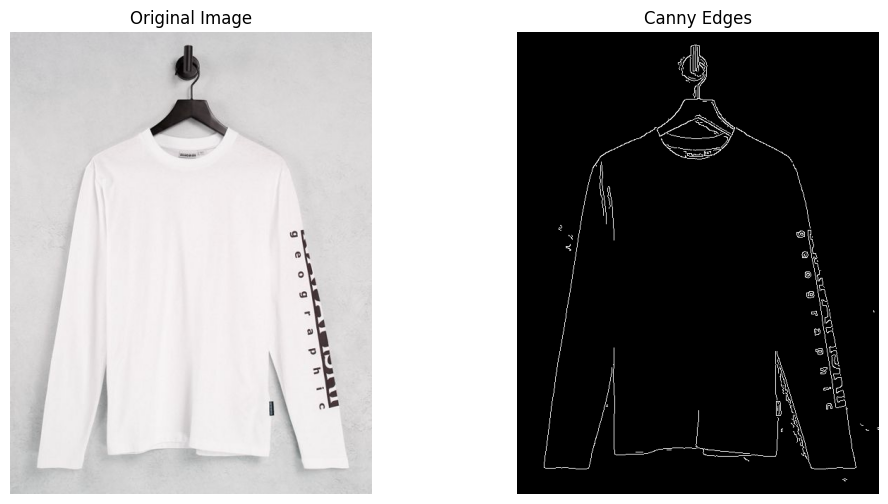

In [23]:
def gaussian_kernel(kernel_size, sigma):
    kernel_range = np.arange(-(kernel_size // 2), kernel_size // 2 + 1)
    kernel = np.exp(-0.5 * (kernel_range ** 2) / sigma ** 2)
    kernel = kernel / np.sum(kernel)
    return kernel

In [24]:
def sobel_filter(image):
    kernel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    gradient_x = convolve2d(image, kernel_x, mode='same', boundary='wrap')
    gradient_y = convolve2d(image, kernel_y, mode='same', boundary='wrap')

    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    gradient_direction = np.arctan2(gradient_y, gradient_x)

    return gradient_magnitude, gradient_direction

In [25]:
def non_maximum_suppression(magnitude, direction):
    angle = np.degrees(direction) % 180
    suppressed = np.zeros_like(magnitude)

    for i in range(1, magnitude.shape[0] - 1):
        for j in range(1, magnitude.shape[1] - 1):
            if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                neighbor_pixels = [magnitude[i, j+1], magnitude[i, j-1]]
            elif 22.5 <= angle[i, j] < 67.5:
                neighbor_pixels = [magnitude[i+1, j-1], magnitude[i-1, j+1]]
            elif 67.5 <= angle[i, j] < 112.5:
                neighbor_pixels = [magnitude[i+1, j], magnitude[i-1, j]]
            else:
                neighbor_pixels = [magnitude[i+1, j+1], magnitude[i-1, j-1]]

            if magnitude[i, j] >= max(neighbor_pixels):
                suppressed[i, j] = magnitude[i, j]

    return suppressed

In [26]:
def hysteresis_thresholding(image, low_threshold_ratio=0, high_threshold_ratio=0.039):
    high_threshold = np.max(image) * high_threshold_ratio
    low_threshold = high_threshold * low_threshold_ratio

    strong_edges_row, strong_edges_col = np.where(image >= high_threshold)
    weak_edges_row, weak_edges_col = np.where(
        (image >= low_threshold) & (image < high_threshold))

    output_image = np.zeros_like(image, dtype=np.uint8)
    output_image[strong_edges_row, strong_edges_col] = 255
    output_image[weak_edges_row, weak_edges_col] = 20  # Weak edges
    return output_image

In [27]:
# Path to the folder containing .jpg files
input_folder = "shirts"
# Path to the folder where you want to save the resulting images
output_folder = "output_images"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Loop through each file in the input folder
for file_name in os.listdir(input_folder):
    if file_name.endswith(".jpg"):
        # Read the image
        image_path = os.path.join(input_folder, file_name)
        image = np.array(Image.open(image_path))

        # Convert the image to grayscale
        gray = rgb_to_grayscale(image)

        # Define Gaussian kernel
        kernel_size = 5
        sigma = 0.3 * ((kernel_size - 1) * 0.5 - 1) + 0.8
        kernel = gaussian_kernel(kernel_size, sigma)
        gaussian_mask = np.outer(kernel, kernel.transpose())

        # Apply Gaussian blur using kernel convolution
        blurred_single_channel = convolve2d(
            gray, gaussian_mask, mode='same', boundary='wrap')
        blurred = blurred_single_channel.astype(np.uint8)

        # Perform Canny edge detection
        magnitude, direction = sobel_filter(blurred)
        magnitude_suppressed = non_maximum_suppression(magnitude, direction)
        edges = hysteresis_thresholding(magnitude_suppressed)

        # Save the edges image
        output_path = os.path.join(output_folder, file_name)
        Image.fromarray(edges).save(output_path)

print("Images processed and saved successfully.")

KeyboardInterrupt: 